### Capstone Project: NYC-311 Service Requests Analysis by Heriberto Varela.

In [141]:
import time
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import squarify
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import re
from wordcloud import WordCloud

## EDA.

In [183]:
# retrieve processed dataset
req_df = pd.read_parquet("req_df_clean.parquet.gzip")

In [184]:
req_df['created_date'].head(1)

0   2023-06-10 21:11:28
Name: created_date, dtype: datetime64[ns]

Earliest request is from 2023-06-10.

In [185]:
req_df['created_date'].tail(1)

2936142   2024-05-06 00:57:00
Name: created_date, dtype: datetime64[ns]

Latest request is from 2024-05-06.

In [186]:
req_df['complaint_type'].unique()

<StringArray>
['Non-Emergency Police Matter',         'Noise - Residential',
             'Noise - Vehicle',     'Noise - Street/Sidewalk',
       'Real Time Enforcement',                'Noise - Park',
          'Noise - Commercial',            'Blocked Driveway',
             'Illegal Parking',               'Lot Condition',
 ...
  'DOB Posted Notice or Order',   'Public Payphone Complaint',
        'Non-Residential Heat',              'Unlicensed Dog',
    'Building Marshals office',         'Seasonal Collection',
                         'SNW',   "Building Marshal's Office",
       'Executive Inspections',  'Sustainability Enforcement']
Length: 201, dtype: string

We have 201 unique complaint types, ideally I'll be able to reconcile them. With a quick glance we can see that there are multiple types of noise complaints that can be easily reconciled. Further cleaning and analysis will be done to better represent complaint types in the final version of EDA.

In [187]:
np.max(req_df['closed_date'] - req_df['created_date'])

Timedelta('324 days 10:24:33')

Roughly, the max resolution time of a service request was 324 days and 10 hours.

In [188]:
np.mean(req_df['closed_date'] - req_df['created_date'])

Timedelta('6 days 20:44:21.869352067')

Roughly, it takes 6 days and 20 hours on average for a service request to be closed.

We can group the total requests made per Borough, to see if there's a significant difference in the amount of requests made.

In [189]:
# group by borough to get total requests made, ignore "uncategorized" since it's not a significant amount of requests
borough_totals = req_df.groupby(by="borough").count()
borough_totals = borough_totals.loc[borough_totals['created_date'] > 400]

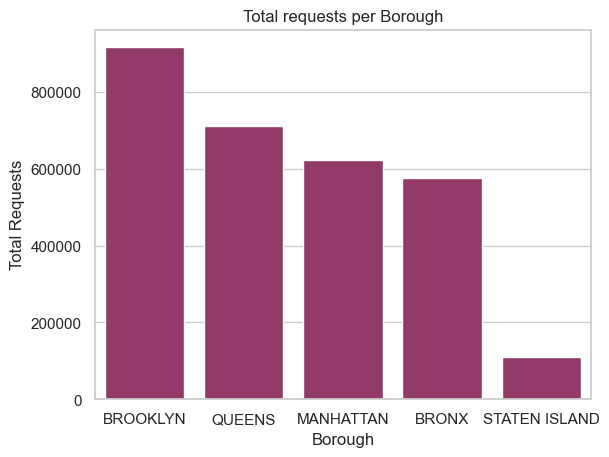

In [190]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x=borough_totals.index, y='created_date', data=borough_totals, color='#9F2B68', 
                  order=borough_totals.sort_values('created_date',ascending=False).index)
plt.title('Total requests per Borough')
plt.xlabel('Borough')
plt.ylabel('Total Requests')
plt.show()

We can see most requests are made from Brooklyn, with 916,833 total requests. Queens comes in second, then Manhattan, the Bronx, and Staten Island in last place. Population sizes and distribution are aspects worth exploring to see how representative these values are.

We can group the requests made per month for each year to see any significant differences as well.

In [191]:
# group by month and year to get totals
monthly_totals = req_df.groupby(by=[req_df.created_date.dt.month, req_df.created_date.dt.year]).count()
monthly_totals.index.rename(['month', 'year'], inplace=True)
monthly_totals = monthly_totals[['created_date']]

In [192]:
# separate by year since I don't currently have consistent monthly data for both years
monthly_totals_2023 = monthly_totals[monthly_totals.index.get_level_values("year").isin([2023])]
monthly_totals_2023.reset_index(inplace=True)
monthly_totals_2024 = monthly_totals[monthly_totals.index.get_level_values("year").isin([2024])]
monthly_totals_2024.reset_index(inplace=True)

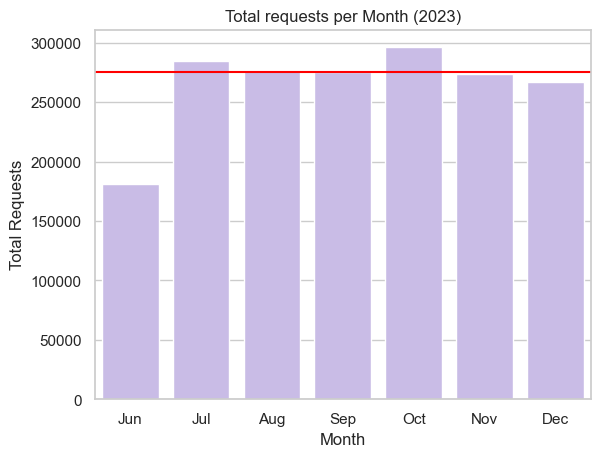

In [193]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x='month', y='created_date', data=monthly_totals_2023, color='#C6B5ED')
plt.title('Total requests per Month (2023)')
plt.xticks(np.arange(0,7),['Jun','Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.axhline(y=np.nanmedian(monthly_totals_2023['created_date']), color='red')
plt.xlabel('Month')
plt.ylabel('Total Requests')
plt.show()

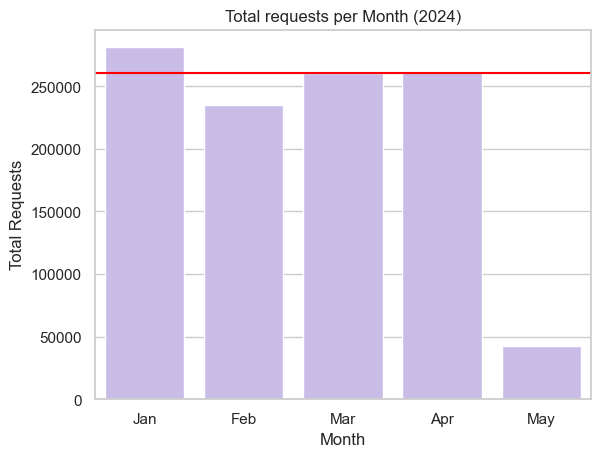

In [194]:
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x='month', y='created_date', data=monthly_totals_2024, color='#C6B5ED')
plt.title('Total requests per Month (2024)')
plt.xticks(np.arange(0,5),['Jan','Feb','Mar', 'Apr', 'May'])
plt.axhline(y=np.nanmedian(monthly_totals_2024['created_date']), color='red')
plt.xlabel('Month')
plt.ylabel('Total Requests')
plt.show()

There is some variation, but no discernable upward or downward trends. The average number of requests marked by the read line on both graphs indicates that there is no significant difference, considering the fact that we are working with an incomplete number of requests for the month of May in 2024.

We'll mostly be interested in the insights we can get from requests that have already been resolved. Below a column is added to indicate whether a request has been closed or not, and further analysis is done on this subset of the requests.

In [195]:
req_df['closed'] = 0

In [196]:
req_df['closed'].loc[req_df['closed_date'].notnull()] = 1

In [197]:
req_df['closed'].sum()

2768004

In [198]:
req_df['closed_date'].isnull().sum()

168139

The majority get a closed date, further analysis using ```resolution_description``` can tell us more about what actions are being registered as resolutions.

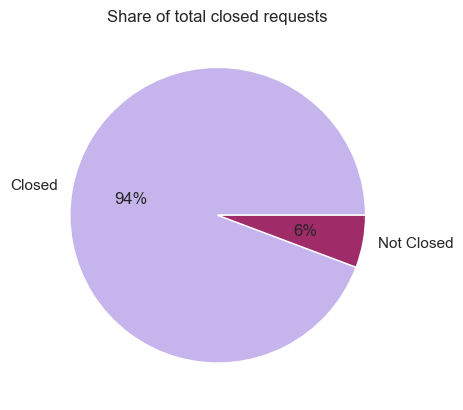

<Figure size 640x480 with 0 Axes>

In [199]:
plt.pie([req_df['closed'].sum(), req_df['closed_date'].isnull().sum()], labels=['Closed', 'Not Closed'], colors= ['#C6B5ED', '#9F2B68'], autopct='%.0f%%')
plt.title('Share of total closed requests')
plt.show()
plt.savefig('requests_closed.png')

Another interesting insight is the distribution of the demographic indicators we have so far. Thanks to the initial merge of datasets, we can now get an aggregate by borough.

In [200]:
# group by borough to mean poverty rate and racial diversity index
borough_poverty_diversity = req_df[['borough','poverty_rate_2021','diversity_index_2021']].groupby(by="borough").mean()
borough_poverty_diversity.dropna(inplace=True)
borough_poverty_diversity.reset_index(inplace=True)

In [201]:
# transform dataframe for easier use in grouped bar chart
borough_poverty_diversity.set_index('borough', inplace=True)
borough_poverty_diversity = borough_poverty_diversity.stack().to_frame('value').reset_index()
borough_poverty_diversity.rename(columns={'level_1':'measure'},inplace=True)

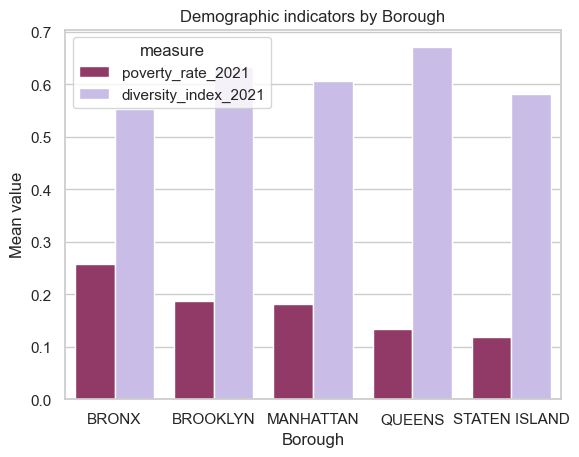

<Figure size 640x480 with 0 Axes>

In [202]:
sns.set(style="whitegrid", color_codes=True)
sns.barplot(data=borough_poverty_diversity, x='borough', y='value', hue='measure', palette= ['#9F2B68', '#C6B5ED'])
plt.title('Demographic indicators by Borough')
plt.xlabel('Borough')
plt.ylabel('Mean value')
plt.show()
plt.savefig('demographics_borough.png')

There is some variation across boroughs for the 2 demographic indicators I've included. The Bronx has the highest mean poverty rate, with the lowest racial diversity index. Queens has the highest mean racial diversity rate, and Staten Island has the lowest poverty rate of all boroughs.

Another interesting insight we can derive from our data at this point is the frequency of complaints by type. This can tell us what problems are reported the most.

In [203]:
text = " ".join(complaint for complaint in req_df['complaint_type'])

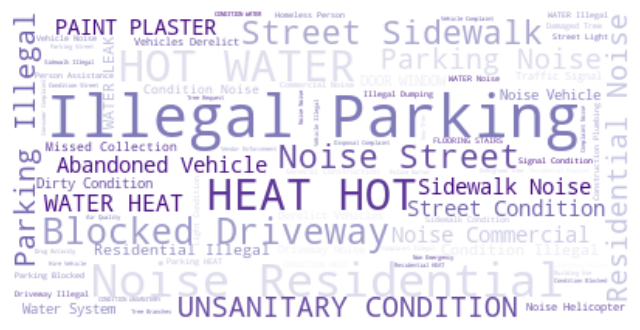

In [204]:
wordcloud = WordCloud(background_color="white",max_words=100, colormap='Purples', random_state=111).generate(str(text))
plt.figure(figsize=(8,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Inspecting this word cloud generated by the overall frequency of each condition type, we can roughly see that illegal parking, heating issues and noise complaints are the issues reported the most. We can further analyze the frequency with the exact counts for each complaint type.

Below see the top 20 complaint types by frequency, with the percentage they represent in our complete dataset.

In [205]:
# group by complaint type
complaint_counts = req_df[["created_date", "complaint_type"]].groupby(by="complaint_type").count()
complaint_counts.rename(columns={"created_date":"total"}, inplace=True)
complaint_counts.sort_values(by="total", ascending=False, inplace=True)
complaint_counts['percentage'] = (complaint_counts['total']/complaint_counts['total'].sum())*100
#print(complaint_counts.to_markdown())

 complaint_type                          |   total |   percentage |
|:----------------------------------------|--------:|-------------:|
| Illegal Parking                         |  444811 | 15.2707      |
| Noise - Residential                     |  268593 |  9.22101     |
| HEAT/HOT WATER                          |  239300 |  8.21536     |
| Blocked Driveway                        |  154584 |  5.30699     |
| Noise - Street/Sidewalk                 |  125842 |  4.32026     |
| UNSANITARY CONDITION                    |   97111 |  3.3339      |
| Noise - Commercial                      |   63262 |  2.17183     |
| Abandoned Vehicle                       |   61536 |  2.11258     |
| Street Condition                        |   59775 |  2.05212     |
| PLUMBING                                |   51805 |  1.77851     |
| PAINT/PLASTER                           |   51137 |  1.75557     |
| Noise                                   |   48050 |  1.64959     |
| Dirty Condition                         |   46839 |  1.60802     |
| Water System                            |   46631 |  1.60088     |
| WATER LEAK                              |   44227 |  1.51835     |
| Noise - Vehicle                         |   43960 |  1.50918     |
| Missed Collection                       |   41843 |  1.4365      |
| DOOR/WINDOW                             |   39562 |  1.35819     |
| Noise - Helicopter                      |   39196 |  1.34563     |
| Rodent                                  |   37015 |  1.27075     |

Given that there are numerous similar complaint types ("Noise", "Noise - Vehicle", etc),  I've decided to reconcile them into 5 groups: 
- Street: Complaints related to issues occurring on a street. Examples: "Illegal Parking", "Blocked Driveway", "Abandoned Vehicle".
- Noise: Complaints noise related. Examples: "Noise - Residential", "Noise - Street/Sidewalk", "Noise - Commercial".
- Building: Complaints related to building amenities. Examples: "HEAT/HOT WATER", "UNSANITARY CONDITION", "PLUMBING".
- Cleanliness: Complaints related to dirty conditions and waste. Examples: "Dirty Condition", "Rodent", "Illegal Dumping".
- Safety: Complaints related to security issues or assistance to individuals. Examples: "Homeless Person Assistance", "Non-Emergency Police Matter", "Consumer Complaint".

This conciliation will allow for easier modeling, and we can further analysis the frequency of this groupings to get a more specific idea of what are the more prominent issues reported.

In [207]:
street_complaints = ["Illegal Parking", "Blocked Driveway", "Abandoned Vehicle", "Street Condition", "Derelict Vehicles", \
                     "Traffic Signal Condition", "Street Light Condition", "Sidewalk Condition", "For Hire Vehicle Complaint", \
                     "Obstruction", "Root/Sewer/Sidewalk Condition", "Street Sweeping Complaint", "Curb Condition", "Outdoor Dining", \
                     "Snow or Ice", "Street Sign - Damaged", "Traffic", "Street Sign - Missing", "Street Sign - Dangling", \
                     "Broken Parking Meter", "DEP Street Condition", "Bike Rack Condition", "Scaffold Safety", \
                     "Bus Stop Shelter Placement", "E-Scooter", "Posting Advertisement", "Cranes and Derricks", \
                     "Public Payphone Complaint", "DEP Sidewalk Condition"]
noise_complaints = ["Noise - Residential", "Noise - Street/Sidewalk", "Noise - Commercial", "Noise", "Noise - Vehicle", \
                    "Noise - Helicopter", "General Construction/Plumbing", "Noise - Park", "Noise - House of Worship"]
building_complaints = ["HEAT/HOT WATER", "UNSANITARY CONDITION", "PLUMBING", "PAINT/PLASTER", "Water System", "WATER LEAK", \
                       "DOOR/WINDOW", "GENERAL", "ELECTRIC", "FLOORING/STAIRS", "APPLIANCE", "Maintenance or Facility", "Elevator", \
                       "Building/Use", "Plumbing", "Boilers", "Electrical", "Paint/Plaster", "Heat/Hot Water", "ELEVATOR", \
                       "OUTSIDE BUILDING", "Door/Window", "Non-Residential Heat", "Appliance", "Water Maintenance", "Electric", \
                       "Drinking Water", "Water Drainage", "Unstable Building", "Building Drinking Water Tank", "Boiler", \
                       "Building Condition", "Window Guard", "Squeegee", "Cooling Tower", "DOB Posted Notice or Order", \
                       "Building Marshal's Office", "Building Marshals office", "Outside Building", "Quality of Life"]
cleanliness_complaints = ["Dirty Condition", "Rodent", "Illegal Dumping", "Encampment", "Sewer", "Graffiti", "New Tree Request", \
                          "Overgrown Tree/Branches", "Damaged Tree", "Residential Disposal Complaint", "Lead", "Food Establishment", \
                          "Dead/Dying Tree", "Dead Animal", "Air Quality", "Indoor Air Quality", "Electronics Waste Appointment", \
                          "Smoking", "Commercial Disposal Complaint", "Litter Basket Request", "Water Leak", "Water Conservation", \
                          "Sanitation Worker or Vehicle Complaint", "Sewer Maintenance", "Food Poisoning", \
                          "Unsanitary Animal Pvt Property", "Abandoned Bike", "Dumpster Complaint", "Lot Condition", \
                          "Hazardous Materials", "Asbestos", "Unsanitary Condition", "School Maintenance", "Litter Basket Complaint", \
                          "Standing Water", "Construction Lead Dust", "Water Quality", "Unsanitary Pigeon Condition", \
                          "Industrial Waste", "Flooring/Stairs", "Wood Pile Remaining", "Indoor Sewage", "Mold", "Tattooing", \
                          "Beach/Pool/Sauna Complaint", "Pet Shop", "Seasonal Collection", "Missed Collection", "Poison Ivy", \
                          "Plant", "Adopt-A-Basket", "Unsanitary Animal Facility", "AHV Inspection Unit", "Recycling Basket Complaint", \
                          "Institution Disposal Complaint", "Public Toilet", "Radioactive Material", "Transfer Station Complaint", \
                          "Oil or Gas Spill", "DSNY Internal", "Peeling Paint"]
safety_complaints = ["Homeless Person Assistance", "Non-Emergency Police Matter", "Consumer Complaint", "Drug Activity", \
                     "Vendor Enforcement", "SAFETY", "Illegal Fireworks", "Bike/Roller/Skate Chronic", "Animal-Abuse", "Lost Property", \
                     "Taxi Complaint", "Panhandling", "Real Time Enforcement", "Animal in a Park", "Mobile Food Vendor", \
                     "Special Projects Inspection Team (SPIT)", "Illegal Tree Damage", "Illegal Posting", "Violation of Park Rules", \
                     "Emergency Response Team (ERT)", "Drinking", "Unleashed Dog", "Day Care", "Bus Stop Shelter Complaint", \
                     "Urinating in Public", "Investigations and Discipline (IAD)", "General", "Taxi Report", "Harboring Bees/Wasps", \
                     "Uprooted Stump", "BEST/Site Safety", "Illegal Animal Kept as Pet", "For Hire Vehicle Report", "Mosquitoes", \
                     "Green Taxi Complaint", "Safety", "Disorderly Youth", "LinkNYC", "Taxi Compliment", "Illegal Animal Sold", \
                     "Incorrect Data", "Found Property", "Dept of Investigations", "Green Taxi Report", "Animal Facility - No Permit", \
                     "Special Natural Area District (SNAD)", "Borough Office", "Lifeguard", "Retailer Complaint", \
                     "Dispatched Taxi Complaint", "Special Operations", "Taxi Licensee Complaint", "Calorie Labeling", "SNW", \
                     "FHV Licensee Complaint", "X-Ray Machine/Equipment", "Tanning", "Construction Safety Enforcement", "Unlicensed Dog", \
                     "Sustainability Enforcement", "Trans Fat", "Executive Inspections"]

In [208]:
req_df['street_complaints'] = 0
req_df['noise_complaints'] = 0
req_df['building_complaints'] = 0
req_df['cleanliness_complaints'] = 0
req_df['safety_complaints'] = 0

In [209]:
req_df['street_complaints'].loc[req_df['complaint_type'].isin(street_complaints)] = 1
req_df['noise_complaints'].loc[req_df['complaint_type'].isin(noise_complaints)] = 1
req_df['building_complaints'].loc[req_df['complaint_type'].isin(building_complaints)] = 1
req_df['cleanliness_complaints'].loc[req_df['complaint_type'].isin(cleanliness_complaints)] = 1
req_df['safety_complaints'].loc[req_df['complaint_type'].isin(safety_complaints)] = 1

In [210]:
complaint_groups = ['Street','Noise','Building','Cleanliness','Safety']
cg_totals = [req_df['street_complaints'].sum(), req_df['noise_complaints'].sum(), req_df['building_complaints'].sum(), \
             req_df['cleanliness_complaints'].sum(), req_df['safety_complaints'].sum()]

First, we can group the requests  by these new complaint groupings, see if the frequency we observed earlier has shifted.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


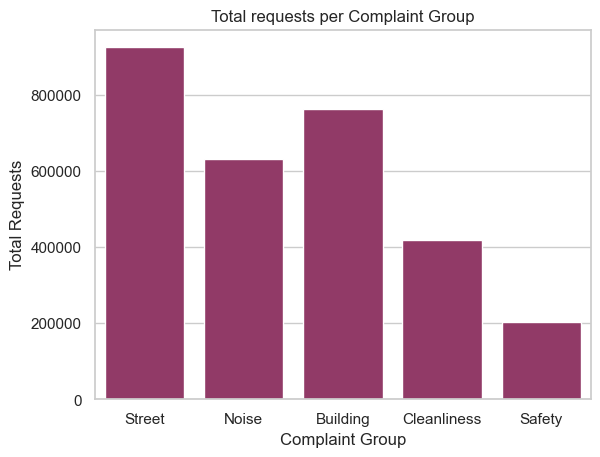

In [211]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x=complaint_groups, y=cg_totals, color='#9F2B68')
plt.title('Total requests per Complaint Group')
plt.xlabel('Complaint Group')
plt.ylabel('Total Requests')
plt.show()

We can see that street and building related incidents are reported the most. This is consistent with the word cloud included above. Safety being the grouping with the lowest amount of incidents reported could indicate that most of these could be deemed urgent, therefore reported by calling other city services like 911 instead.

It's also important to consider that the number of complaint types on each grouping is not equal, so we should not take these frequencies as 1:1 representations of their total share of reports. The noise grouping frequency comes in third even though it has considerably less complaint types forming it. 

Reconciling the complaint types and forming consistent groupings could be something worth pursuing by the city's 311 department. This could allow for better reporting and quicker identification of issues with how these reports are dealt with.

We can further analyze the frequency of these complaint groupings by borough.

In [212]:
boroughs = list(borough_totals.index)

In [213]:
bronx_cg_totals = [req_df['street_complaints'].loc[req_df['borough'] == "BRONX"].sum(), \
                   req_df['noise_complaints'].loc[req_df['borough'] == "BRONX"].sum(), \
                   req_df['building_complaints'].loc[req_df['borough'] == "BRONX"].sum(), \
                   req_df['cleanliness_complaints'].loc[req_df['borough'] == "BRONX"].sum(), \
                   req_df['safety_complaints'].loc[req_df['borough'] == "BRONX"].sum()]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


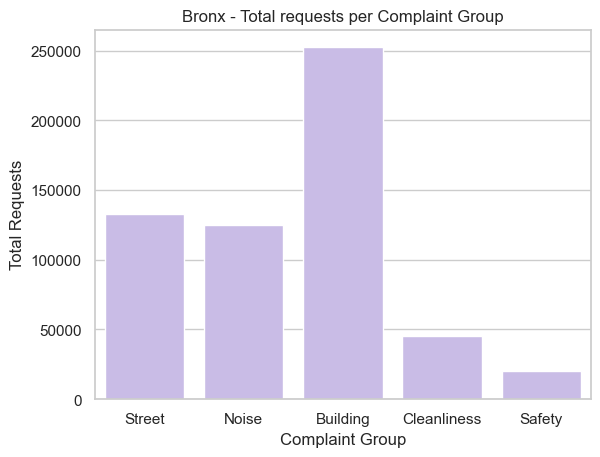

In [214]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x=complaint_groups, y=bronx_cg_totals, color='#C6B5ED')
plt.title('Bronx - Total requests per Complaint Group')
plt.xlabel('Complaint Group')
plt.ylabel('Total Requests')
plt.show()

The top complaint grouping in the Bronx is Building by a large margin. This could represent a lack of quality controls on buildings' amenities and services. In comparison to other boroughs, the Bronx has had the largest housing development projects in recent years. This rapid expansion could be one of the reasons these complaints are more prevalent. 

In [215]:
brooklyn_cg_totals = [req_df['street_complaints'].loc[req_df['borough'] == "BROOKLYN"].sum(), \
                      req_df['noise_complaints'].loc[req_df['borough'] == "BROOKLYN"].sum(), \
                      req_df['building_complaints'].loc[req_df['borough'] == "BROOKLYN"].sum(), \
                      req_df['cleanliness_complaints'].loc[req_df['borough'] == "BROOKLYN"].sum(), \
                      req_df['safety_complaints'].loc[req_df['borough'] == "BROOKLYN"].sum()]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


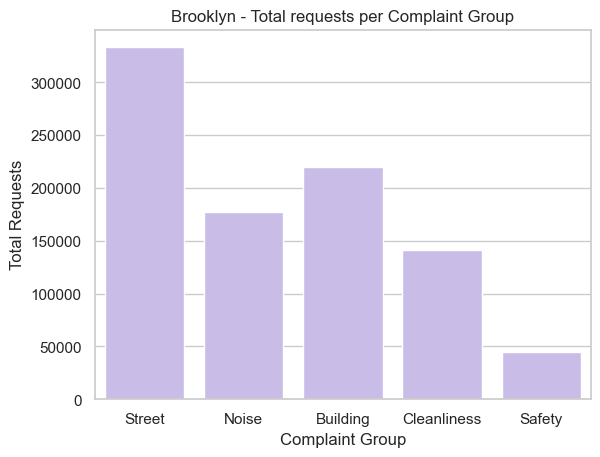

In [216]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x=complaint_groups, y=brooklyn_cg_totals, color='#C6B5ED')
plt.title('Brooklyn - Total requests per Complaint Group')
plt.xlabel('Complaint Group')
plt.ylabel('Total Requests')
plt.show()

The top complaint grouping in Brooklyn is Street, with the Building, Noise and Cleanliness not far behind. Safety is the lowest, as expected from the general frequency we observed before. 

In [217]:
manhattan_cg_totals = [req_df['street_complaints'].loc[req_df['borough'] == "MANHATTAN"].sum(), \
                      req_df['noise_complaints'].loc[req_df['borough'] == "MANHATTAN"].sum(), \
                      req_df['building_complaints'].loc[req_df['borough'] == "MANHATTAN"].sum(), \
                      req_df['cleanliness_complaints'].loc[req_df['borough'] == "MANHATTAN"].sum(), \
                      req_df['safety_complaints'].loc[req_df['borough'] == "MANHATTAN"].sum()]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


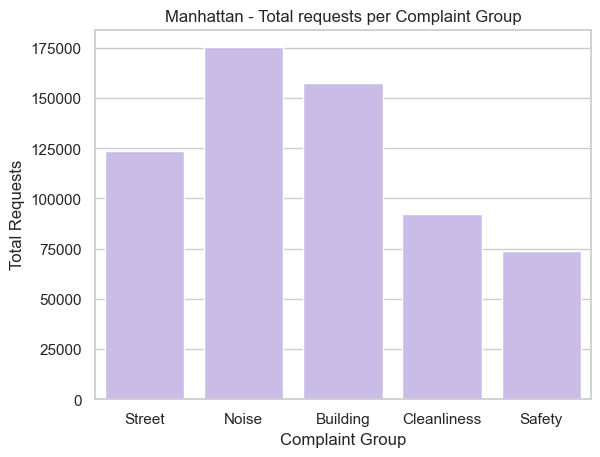

In [218]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x=complaint_groups, y=manhattan_cg_totals, color='#C6B5ED')
plt.title('Manhattan - Total requests per Complaint Group')
plt.xlabel('Complaint Group')
plt.ylabel('Total Requests')
plt.show()

The top complaint grouping in Manhattan is Noise, with Building being a close second. Considering the population density of Manhattan, these two groupings being the top makes sense. The Safety grouping has the largest ocurrence in this borough. The Street grouping has a lower frequency, which tracks with the fact that public transportation is more efficient in Manhattan than in any other borough.

In [219]:
queens_cg_totals = [req_df['street_complaints'].loc[req_df['borough'] == "QUEENS"].sum(), \
                      req_df['noise_complaints'].loc[req_df['borough'] == "QUEENS"].sum(), \
                      req_df['building_complaints'].loc[req_df['borough'] == "QUEENS"].sum(), \
                      req_df['cleanliness_complaints'].loc[req_df['borough'] == "QUEENS"].sum(), \
                      req_df['safety_complaints'].loc[req_df['borough'] == "QUEENS"].sum()]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


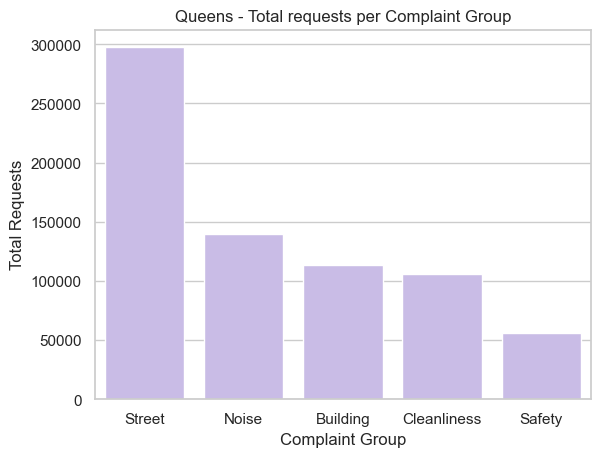

In [220]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x=complaint_groups, y=queens_cg_totals, color='#C6B5ED')
plt.title('Queens - Total requests per Complaint Group')
plt.xlabel('Complaint Group')
plt.ylabel('Total Requests')
plt.show()

The top complaint grouping in Queens is Street by a large margin. This could represent poor quality controls of the streets in the borough. It could also show us that a larger driving population lives in Queens compared to the other boroughs. 

In [221]:
statenisland_cg_totals = [req_df['street_complaints'].loc[req_df['borough'] == "STATEN ISLAND"].sum(), \
                      req_df['noise_complaints'].loc[req_df['borough'] == "STATEN ISLAND"].sum(), \
                      req_df['building_complaints'].loc[req_df['borough'] == "STATEN ISLAND"].sum(), \
                      req_df['cleanliness_complaints'].loc[req_df['borough'] == "STATEN ISLAND"].sum(), \
                      req_df['safety_complaints'].loc[req_df['borough'] == "STATEN ISLAND"].sum()]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


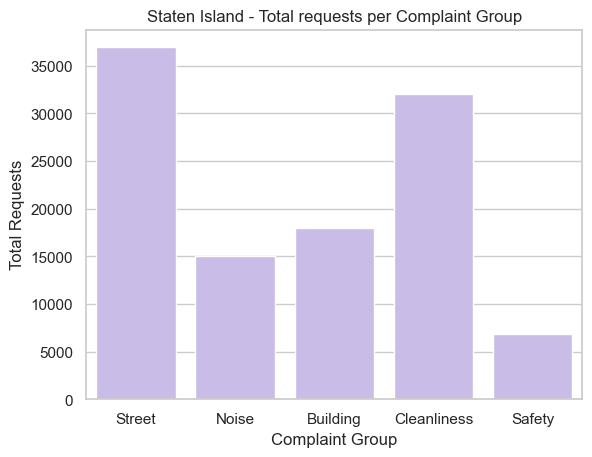

In [222]:
sns.set(style="whitegrid", color_codes=True)
fig = sns.barplot(x=complaint_groups, y=statenisland_cg_totals, color='#C6B5ED')
plt.title('Staten Island - Total requests per Complaint Group')
plt.xlabel('Complaint Group')
plt.ylabel('Total Requests')
plt.show()

The top complaint group in Staten Island is Street with Cleanliness as a close second. Compared to the other boroughs, Cleanliness has a larger share of the total frequency in Staten Island, this could represent a lack of consistent cleaning services in public areas such as streets and parks.

Given that each request in our dataset containts which city agency is tasked with its resolution, we can analyze the performance of each of the appearing agencies in the timeframe spanned in out dataset (2023 - 2024).

In [224]:
req_df['agency'].unique()

<StringArray>
[      'NYPD',        'DOB',       'DSNY',        'DHS',        'DOT',
        'HPD',        'EDC',        'DEP',      'DOHMH',        'DPR',
        'TLC',       'DCWP',        'DOE',        'OTI', 'NYC311-PRD']
Length: 15, dtype: string

We have 15 agencies in total, we can group the requests to get the total frequency per agency.

In [225]:
agency_totals = req_df.groupby(by="agency").count()

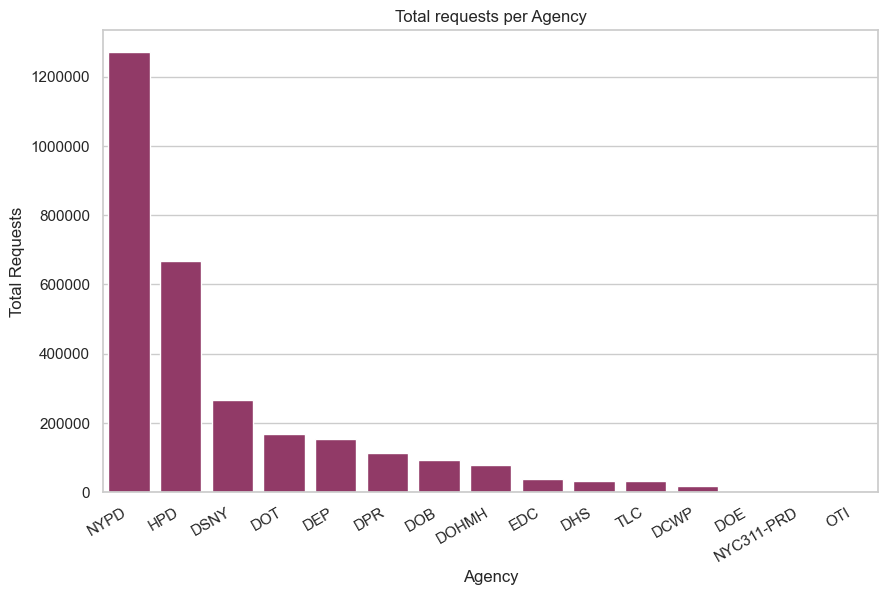

In [226]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(10,6))
fig = sns.barplot(x=agency_totals.index, y='created_date', data=agency_totals, color='#9F2B68', 
                  order=agency_totals.sort_values('created_date',ascending=False).index)
plt.title('Total requests per Agency')
plt.xlabel('Agency')
plt.ylabel('Total Requests')
plt.setp(fig.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

The NYPD (New York City Police Department) has by far the largest amount of requests, with the HPD (Department of Housing Preservation and Development) coming in second, and the DSNY (Department of Sanitation) in third. Comparing these frequencies with the resource allocation of each department could yield interesting results, and help identify potential under/over-funding.

See below the full names of each of the agencies in the dataset.

In [227]:
agency_names_df = req_df[['agency', 'agency_name']]
agency_names_df.drop_duplicates(inplace=True)
#print(agency_names_df.to_markdown(index=False))

| agency     | agency_name                                        |
|:-----------|:---------------------------------------------------|
| NYPD       | New York City Police Department                    |
| DOB        | Department of Buildings                            |
| DSNY       | Department of Sanitation                           |
| DHS        | Department of Homeless Services                    |
| DOT        | Department of Transportation                       |
| HPD        | Department of Housing Preservation and Development |
| EDC        | Economic Development Corporation                   |
| DEP        | Department of Environmental Protection             |
| DOHMH      | Department of Health and Mental Hygiene            |
| DPR        | Department of Parks and Recreation                 |
| TLC        | Taxi and Limousine Commission                      |
| DCWP       | Department of Consumer and Worker Protection       |
| DOE        | Department of Education                            |
| OTI        | Office of Technology and Innovation                |
| NYC311-PRD | Service Organization                               |

In [228]:
# only include requests that have a closed date after created date, potential data entry issue
req_df.drop(req_df[req_df['closed_date'] < req_df['created_date']].index, inplace=True)

To analyze the performance of each of the agencies, we can exctract the number of days that passed until a resolution was registered for each of the requests made.

In [229]:
# for reporting purposes, we'll store the time until resolution in days
req_df["days_until_resolution"] = (req_df["closed_date"] - req_df["created_date"]).dt.days

See below the list of agencies ordered by the percentage of requests they've completed in 2023 and half of 2024, with their average resolution time in days.

In [230]:
agency_stats_df = req_df.groupby(['agency', 'agency_name']) \
                     .agg({'created_date':'count','closed':'sum', 'days_until_resolution':'mean'}) \
                     .rename(columns={'created_date':'Total','closed':'Resolved','days_until_resolution':'Average Resolution Time (Days)'}) \
                     .reset_index()
agency_stats_df['Percentage'] = agency_stats_df['Resolved']/agency_stats_df['Total']
agency_stats_df.sort_values(by="Percentage", ascending=False, inplace=True)
#print(agency_stats_df.to_markdown(index=False))

| agency     | agency_name                                        |   Total |   Resolved |   Average Resolution Time (Days) |   Percentage |
|:-----------|:---------------------------------------------------|--------:|-----------:|---------------------------------:|-------------:|
| NYPD       | New York City Police Department                    | 1270921 |    1270568 |                        0.0029113 |     0.999722 |
| DOB        | Department of Buildings                            |   93544 |      93443 |                       21.3846    |     0.99892  |
| DSNY       | Department of Sanitation                           |  266887 |     261535 |                        4.64737   |     0.979947 |
| DEP        | Department of Environmental Protection             |  153640 |     149367 |                        3.06187   |     0.972188 |
| DOT        | Department of Transportation                       |  165787 |     157152 |                        6.35532   |     0.947915 |
| HPD        | Department of Housing Preservation and Development |  667836 |     630731 |                       12.8035    |     0.94444  |
| NYC311-PRD | Service Organization                               |     409 |        383 |                       12.3473    |     0.93643  |
| OTI        | Office of Technology and Innovation                |     152 |        137 |                       11.7226    |     0.901316 |
| DOE        | Department of Education                            |    1261 |       1113 |                       31.8922    |     0.882633 |
| DCWP       | Department of Consumer and Worker Protection       |   17688 |      13944 |                       16.7338    |     0.788331 |
| TLC        | Taxi and Limousine Commission                      |   32063 |      22598 |                       52.2727    |     0.7048   |
| EDC        | Economic Development Corporation                   |   39196 |      25824 |                       49.6422    |     0.658843 |
| DPR        | Department of Parks and Recreation                 |  114283 |      74174 |                       36.1183    |     0.649038 |
| DOHMH      | Department of Health and Mental Hygiene            |   77635 |      49503 |                        1.95295   |     0.637638 |
| DHS        | Department of Homeless Services                    |   33458 |      16149 |                        1.76147   |     0.482665 |

The NYPD has the largest percentage of resolution, with almost 100%, and an average of less than a day. This is lower than all other agencies by a large margin. The DOB, DSNY and DEP are listed next, with almost all requests marked as resolved but with varying average resolution times. As mentioned before, numbers could be used to identify issues with underfunding, with long resolution times possibly indicating a need for city employees.

The type of request should also be considered, given that some complaints may take considerably more effort from the agencies to be marked as resolved.

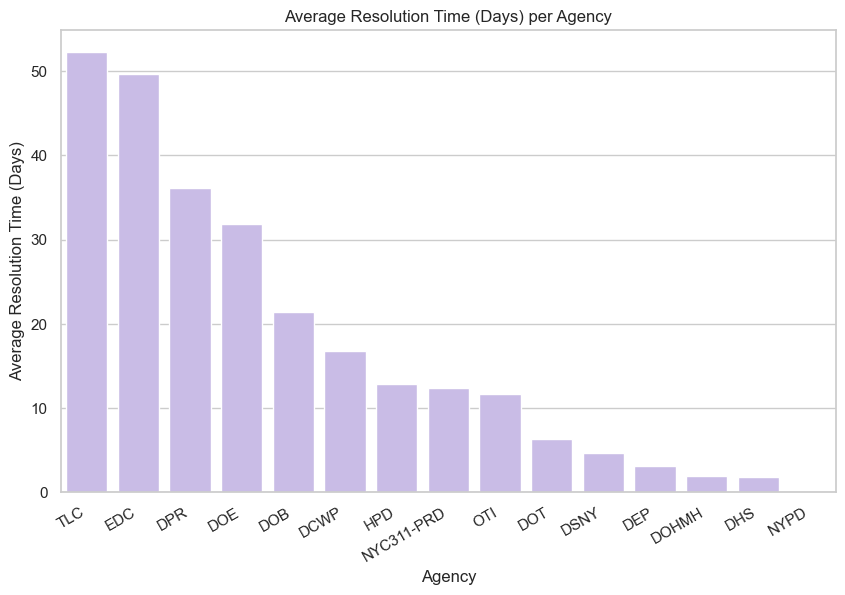

In [231]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(10,6))
fig = sns.barplot(x=agency_stats_df['agency'], y=agency_stats_df['Average Resolution Time (Days)'], color='#C6B5ED',
                  order=agency_stats_df.sort_values('Average Resolution Time (Days)',ascending=False)['agency'])
plt.title('Average Resolution Time (Days) per Agency')
plt.xlabel('Agency')
plt.ylabel('Average Resolution Time (Days)')
plt.setp(fig.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

The TLC, EDC and DPR are the top 3 longest average resolution times with 50 to 30 days. Further analysis of the type of complaints solved by these agencies can be performed to identify any issues with staffing or resources provided.

In [232]:
# include time until resolution as timedelta format for reporting purposes
req_df["time_until_resolution"] = (req_df["closed_date"] - req_df["created_date"])

In [233]:
longest_resolved_df = req_df[['agency', 'agency_name', 'descriptor', 'resolution_description',
                              'time_until_resolution']].loc[req_df['closed']==1] \
                                                       .sort_values(by='time_until_resolution', ascending=False).head(10)
#print(longest_resolved_df.to_markdown(index=False))

As mentioned before, it's important to consider that each complaint type may require a varying degree of effort from the city agency to be marked as resolved. See below a list of the top and bottom 10 requests by the time it took until they were resolved, with descriptions of the issue and its resolution included.

| agency   | agency_name                                        | descriptor                                       | resolution_description                                                                                                                                                                                                                                   | time_until_resolution   |
|:---------|:---------------------------------------------------|:-------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------|
| HPD      | Department of Housing Preservation and Development | COOKING GAS                                      | The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.                                                                                                     | 324 days 10:24:33       |
| HPD      | Department of Housing Preservation and Development | PESTS                                            | The Department of Housing Preservation and Development contacted an occupant of the apartment and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.      | 322 days 21:12:57       |
| DOB      | Department of Buildings                            | Illegal Conversion Of Residential Building/Space | The Department of Buildings has made a second attempt to conduct an inspection of this premises and was denied access. No further attempts will be made.                                                                                                 | 321 days 06:20:43       |
| DPR      | Department of Parks and Recreation                 | Hitting Building                                 | Under NYC Parksâ Tree Risk Management Program, work is prioritized to address the conditions with the highest risk first.  NYC Parks determined that the issue will be addressed in the next pruning cycle through the routine block pruning program.  For more information about the Tree Risk Management Program, visit the NYC Urban Forest page on the NYC Parks website at nyc.gov/parks/trees.   To learn more about the trees in your neighborhood, visit the NYC Tree Map at nyc.gov/parks/treemap.                                                                                                                                                                                                                                                          | 320 days 21:14:51       |
| DOB      | Department of Buildings                            | Adult Establishment                              | The Department of Buildings investigated this complaint and issued an Office of Administrative Trials and Hearings (OATH) summons.                                                                                                                       | 319 days 13:25:36       |
| HPD      | Department of Housing Preservation and Development | PESTS                                            | The Department of Housing Preservation and Development was not able to gain access to inspect the following conditions. The complaint has been closed. If the condition still exists, please file a new complaint.                                       | 318 days 23:55:11       |
| HPD      | Department of Housing Preservation and Development | NO LIGHTING                                      | The Department of Housing Preservation and Development was not able to gain access to inspect the following conditions. The complaint has been closed. If the condition still exists, please file a new complaint.                                       | 318 days 14:25:19       |
| DPR      | Department of Parks and Recreation                 | Hitting Building                                 | The Service Request submitted did not have sufficient location or complaint information for NYC Parks to respond.  Please submit a new Service Request with adequate site details, including a full street address and descriptive location information. | 317 days 01:08:40       |
| DPR      | Department of Parks and Recreation                 | Remove Stump                                     | The Service Request submitted did not have sufficient location or complaint information for NYC Parks to respond.  Please submit a new Service Request with adequate site details, including a full street address and descriptive location information. | 317 days 00:28:00       |
| DOT      | Department of Transportation                       | Multiple Street Lights Out                       | Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.                                                                                                                                                                                                                                                          | 316 days 20:52:00       |

The top requests with the longest times until resolution come from different agencies, and from the top 3 agencies with the longest average time to resolution we only see the DPR appear on this list. This could tell us that the distribution of resolution times for each agency varies, further analysis on this could be done to identify outliers.

From the description of the issues, we see mostly amenities and building cleanliness issues. The DPR and the DOB are in the top 5 agencies with longest average resolution times. Further analysis on these outliers could be done to identify ways of expediting their resolution.

In [234]:
shortest_resolved_df = req_df[['agency', 'agency_name', 'descriptor', 'resolution_description',
                               'time_until_resolution']].loc[req_df['closed']==1] \
                                                        .sort_values(by='time_until_resolution').head(15)
#print(shortest_resolved_df.to_markdown(index=False))

| agency   | agency_name                             | descriptor                          | resolution_description                                                                                                                                                         | time_until_resolution   |
|:---------|:----------------------------------------|:------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------|
| DSNY     | Department of Sanitation                | Derelict Vehicles                   | The owner claimed the vehicle.Â Your request is now closed and no further action will be taken.                                                                                | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Rat Sighting                        | The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.                                            | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Condition Attracting Rodents        | The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.                                            | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Container - Over 5 Gallons          | An inspection of the property was conducted and the owner was issued a summons. Follow-up inspections will be scheduled.                                                       | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Rat Sighting                        | The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection. | 0 days 00:00:00         |
| DEP      | Department of Environmental Protection  | Hydrant Running Full (WA4)          | The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.           | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Signs of Rodents                    | The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection. | 0 days 00:00:00         |
| DOB      | Department of Buildings                 | Curb Cut/Driveway/Carport - Illegal | Your Service Request has been submitted to the Department of Buildings.  Please check back later for status.                                                                   | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Dog                                 | The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.                                            | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Rat Sighting                        | The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.                                            | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Rat Sighting                        | The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.                                            | 0 days 00:00:00         |
| DOT      | Department of Transportation            | Pothole                             | The Department of Transportation determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.                     | 0 days 00:00:00         |
| DOT      | Department of Transportation            | Pothole                             | The Department of Transportation determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.                     | 0 days 00:00:00         |
| DOHMH    | Department of Health and Mental Hygiene | Rat Sighting                        | The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.                                            | 0 days 00:00:00         |
| DEP      | Department of Environmental Protection  | Hydrant Running (WC3)               | The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.           | 0 days 00:00:00         |

The bottom 10 requests by resolution time included have 0 as passed. This shows us that some requests are marked as resolved when they're created. This could hinder the reporting on these issues. However we see that most of the resolutions described here as marked with a "follow-up". This could represent that some agencies mark requests as resolved even when a follow up will be perfomed at a later date.

Overall, we were able to gather interesting insights on the borough and agency level from our requests dataset. More granular analysis can be done to identify issues on the community board level as well. 

In [236]:
# export to parquet for easier retrieval
req_df.to_parquet('req_df_for_model.parquet.gzip', compression='gzip')